<a href="https://colab.research.google.com/github/KSY1526/myblog/blob/master/_notebooks/PythonMachine5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 머신러닝 가이드) 5-4 실전분석(자전거 대여 수요 예측)

# 캐글에서 데이터 직접 불러오기

In [1]:
pip install kaggle --upgrade

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ksy1998","key":"0c820de52cea65ec11954012ef8b00d2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle competitions download -c bike-sharing-demand

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 50.8MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 44.9MB/s]
  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 40.4MB/s]


# 데이터 둘러보기 및 가공

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

bike_df = pd.read_csv('./train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


변수는 11개, 10886개 데이터가 있습니다. datetime변수는 가공이 필요합니다.

In [10]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


결측값은 없습니다.

In [17]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


pd.to_datetime 함수를 통해 데이터 타임을 datetime으로 바꿨습니다.

datetime 데이터 타입은 year, month 등등으로 구분할 수 있습니다.

이를 활용하여 년, 달, 날, 시간 변수로 각각 생성하였습니다.

In [18]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

datetime 변수는 분해를 했기 때문에 원본 변수가 필요 없어졌습니다.

casual + registered = count 변수 이므로 두 변수 모두 제외하겠습니다.

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    mae_val = mean_absolute_error(y, pred)
    print('rmsle :', np.round(rmsle_val, 4), 'rmse :', np.round(rmse_val, 4), 'mse :', np.round(mae_val, 4))

이번 분석의 성능 평가 방법은 rmsle 이기 때문에 이를 구현했습니다.

# 첫번째 분석

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis = 1, inplace = False)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size = 0.3, 
                                                    random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

evaluate_regr(y_test, pred)

rmsle : 1.1647 rmse : 140.8996 mse : 105.9244


실제 타겟 값이 대여 횟수임으로 지금 rmse 값은 매우 크다고 볼 수 있습니다.

In [25]:
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    print(result_df.sort_values('diff', ascending= False)[:n_tops])

get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


실제값과 예측값이 가장 차이가 큰 5개 데이터를 출력했습니다.

상당히 차이가 많이 나는걸 볼 수 있는데요.

타겟값의 분포가 치우쳐 있는지 확인을 해볼 필요가 있겠습니다.

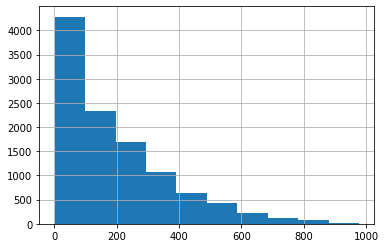

In [26]:
y_target.hist()

오른쪽 꼬리가 매우 두터운 형태임을 알 수 있습니다.

이런 형태일 때 가장 자주 쓰이는 로그변환을 적용해보겠습니다.

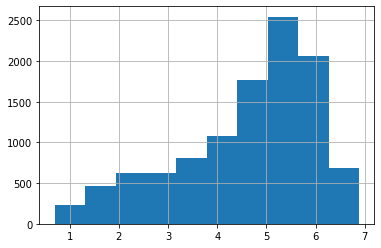

In [27]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

정규분포와는 다소 차이가 있지만 변환 전보다 왜곡 정도가 많이 개선됐습니다.

In [29]:
y_target_log = np.log1p(y_target)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target_log, test_size= 0.3, 
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
pred = lr_reg.predict(x_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

rmsle : 1.0168 rmse : 162.5943 mse : 109.2862


mse 값은 전보다 개선 되었지만 rmse 값은 더 증가하였습니다.

무슨 이유일까요?

# 두번째 분석

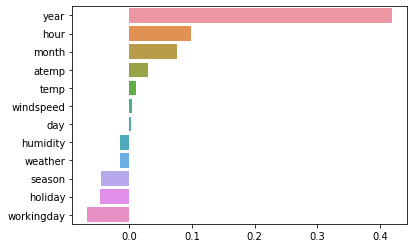

In [30]:
coef = pd.Series(lr_reg.coef_, index=x_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x=coef_sort.values, y = coef_sort.index)

다른 값에 비해 year값이 높습니다. 

year값은 년도인데 년도가 이렇게 큰 영향을 미치는 것을 일반적인 사실로 받아들이기 힘듭니다.

이유를 추정해보자면 연도 변수의 값이 큰 점을 들 수 있습니다.(2011,2012)

비슷한 이유로 범주형 변수로 변환할 필요가 있는 변수들을 원핫인코딩방식으로 변환하겠습니다.

In [32]:
x_features_ohe = pd.get_dummies(x_features, columns = ['year', 'month','day','hour','holiday', 'workingday', 
                                                       'season', 'weather'])
x_features_ohe.shape

(10886, 73)

원핫 인코딩 결과 열 개수가 73개로 크게 늘어났습니다.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_features_ohe, y_target_log, test_size= 0.3, 
                                                    random_state=0)

def get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1 = False):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    
    print(model.__class__.__name__)
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1 = True)

LinearRegression
rmsle : 0.5896 rmse : 97.6878 mse : 63.3821
Ridge
rmsle : 0.5901 rmse : 98.5286 mse : 63.8934
Lasso
rmsle : 0.6348 rmse : 113.2188 mse : 72.8027


원핫 인코딩을 적용한 후 결과가 눈에 띄게 좋아졌습니다.

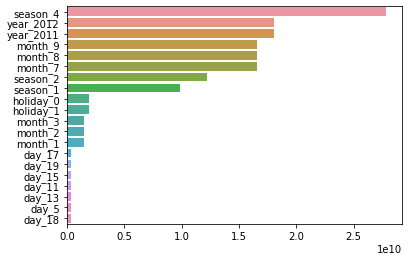

In [37]:
coef = pd.Series(lr_reg.coef_, index=x_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

회귀계수가 높은 피처 20개를 출력해보았습니다.

# 세번째 분석

In [38]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimaters = 500)
lgbm_reg = LGBMRegressor(n_estimaters = 500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, x_train.values, x_test.values, y_train.values, y_test.values, is_expm1=True)

RandomForestRegressor
rmsle : 0.3549 rmse : 50.2976 mse : 31.1562
GradientBoostingRegressor
rmsle : 0.3299 rmse : 53.3352 mse : 32.7448
[16:01:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor
rmsle : 0.4828 rmse : 95.6137 mse : 59.2047
LGBMRegressor
rmsle : 0.3315 rmse : 51.3807 mse : 31.8325


부스팅 모델을 사용하면 더 좋은 성능을 보일 수 있습니다.